In [21]:
%%capture
##! pip install graphviz
#! pip install pyspssio
#! pip install networkx[default]

In [22]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pyspssio
import re
import networkx as nx

sns.set_palette("pastel")
sns.set_theme(style="whitegrid", palette="pastel", context="notebook")

In [23]:
df_dh, meta_dh = pyspssio.read_sav("29-я волна_репрезентативная выборка_SPSS/ДОМОХОЗЯЙСТВА/r29h_os_71.sav")
df_ind, meta_ind = pyspssio.read_sav("29-я волна_репрезентативная выборка_SPSS/ИНДИВИДЫ/r29i_os_73.sav")

In [24]:
#кто проходил опросник, сколько человек в семье
#надо наверное сделать класс
def family_meta_info(seriya, max_chlenov_dh=20):
    who_pass_form = seriya['ya8']
    family_members_num = seriya['y_nfm']
    return who_pass_form, family_members_num

In [25]:
def create_nodes(seriya, max_chlenov_dh=20):
    nodes = []
    for num_chlen in range(1, max_chlenov_dh+1):
        #if (pd.notna(seriya[f'yb{num_chlen}.1'])) & (seriya[f'yb{num_chlen}.2.1']==1):
        if (seriya[f'yb{num_chlen}.2.1']==1):
            ind_number = seriya[f'yidind{num_chlen}']
            
            pol_value = seriya[f'yb{num_chlen}.4']
            pol = None if pd.isna(pol_value) else ('male' if pol_value==1 else 'female' if pol_value==2 else None)
            
            birth_year_value = seriya[f'yb{num_chlen}.5']
            birth_year = None if pd.isna(birth_year_value) else birth_year_value
            
            node = (
                num_chlen,
                {
                'ind_number': ind_number, #'Индивидуальный номер 1-го члена семьи'
                'pol': pol, #'Какого пола этот человек?',
                'birth_year': birth_year, #'В каком году (он/она) родились?'
                }
            )
            nodes.append(node)
        
    return nodes

In [ ]:
# у меня тут изменяются узлы и связи на месте, а не возвращаются
def add_info_from_ind_for_nodes(nodes, df_ind):
    #еще вариант: функция возвращает update_itm
    for node in nodes:
        update_items = {
            'is_adult': True,
            'is_sozhit': False,
            #nation,
            #profession,
            #obrazovaniye
        }
        if node[1]['ind_number'] in df_ind['idind'].tolist():
            seriya_ind = df_ind.loc[(df_ind['idind']==node[1]['ind_number'])].squeeze()
            
            is_adult_value = seriya_ind['y_child'] #те, кому не исполнилось 14 лет
            is_adult = False if is_adult_value==1 else True
            update_items['is_adult'] = is_adult
            
            is_sozhit_value = seriya_ind['y_marst']
            is_sozhit = True if is_sozhit_value==3 else False
            update_items['is_sozhit'] = is_sozhit

        node[1].update(update_items)

In [27]:
def who_lives_here(nodes, structured=True):
    if structured:
        nodes_num = [node[0] for node in nodes]
    else:
        nodes_num = nodes        
    return nodes_num

In [28]:
def create_base_edges(relationship_matrix):
    connection_names = {
        1: 'suprug',
        2: 'blood_ditya',
        3: 'priyem_ditya'
    }
    edges = []
    for node_kuda_num in relationship_matrix.index:
        for node_otkuda_num in relationship_matrix.columns:
            if node_kuda_num>node_otkuda_num:
                edge_type = relationship_matrix.loc[node_kuda_num, node_otkuda_num]
                if edge_type in [1, 2, 3, 4, 5]:
                    if edge_type == 4:
                        node_otkuda, node_kuda = node_otkuda_num, node_kuda_num
                        edge_type = 2
                    elif edge_type == 5:
                        node_otkuda, node_kuda = node_otkuda_num, node_kuda_num
                        edge_type = 3
                    else:
                        node_kuda, node_otkuda = node_otkuda_num, node_kuda_num
                        if edge_type==1:
                            edges.append((node_kuda, node_otkuda, {'edge_type': connection_names[edge_type]}))  
                    edge = (
                        node_otkuda,
                        node_kuda,
                        {
                            'edge_type': connection_names[edge_type], #'Кем 2-ой член семьи приходится 1-му члену семьи?'
                        }
                    ) 
                    edges.append(edge)
                    
    return edges

In [29]:
def add_extended_edges(relationship_matrix, edges):
    for node_kuda_num in relationship_matrix.index:
        for node_otkuda_num in relationship_matrix.columns:
            if node_kuda_num>node_otkuda_num:
                edge_type = relationship_matrix.loc[node_kuda_num, node_otkuda_num]
                if edge_type in [8, 9]:    
                    if edge_type == 9:
                        node_otkuda, node_kuda = node_otkuda_num, node_kuda_num
                        edge_type = 8
                    elif edge_type == 8:
                        node_otkuda, node_kuda = node_kuda_num, node_otkuda_num
                    
                    relevant_edges_1 = [e for e in edges if (e[0]==node_otkuda and e[2]['edge_type']!='blood_ditya')]
                    relevant_edges_2 = [e for e in edges if (e[0]==node_otkuda and e[2]['edge_type']!='priyem_ditya')]
                    relevant_edges = relevant_edges_1 + relevant_edges_2
                    if len(relevant_edges)==0:
                        edge = (
                            node_otkuda,
                            node_kuda,
                            {
                                'edge_type': 'vnuk', #'Кем 2-ой член семьи приходится 1-му члену семьи?'
                            }
                        ) 
                        edges.append(edge)

In [30]:
def change_brak_to_sozhit(nodes, edges):
    for edge in edges:
        ind_1_num = edge[0]
        ind_2_num = edge[1]

        ind_1 = [node for node in nodes if node[0]==ind_1_num][0]
        ind_2 = [node for node in nodes if node[0]==ind_2_num][0]

        if ((edge[2]['edge_type'] == 'suprug') or (edge[2]['edge_type'] == 'sozhitel')) and ((ind_1[1]['is_sozhit']==True ) or (ind_2[1]['is_sozhit']==True)):
            edge[2]['edge_type'] = 'sozhitel'

In [31]:
def create_graph(nodes, edges):
    graph = nx.DiGraph()
    
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    
    return graph

In [32]:
#113 - с прабабушкой без бабушки
#4567 ничего не вывело ((( - 1 член в дх, но о нем нет инфы
#4652 ничего не вывело
#1309 - интересная семья: 9 детей, практически все погодки

In [33]:
def create_relationship_matrix_scratch(seriya, who_pass_form, max_members=20):
    
    all_nodes = set()
    all_nodes.add(int(who_pass_form))
    # Создаем пустую матрицу размером max_members x max_members
    matrix = np.full((max_members+1, max_members+1), '', dtype=object)
    
    for node_kuda_num in range(1, max_members+1):
        for node_otkuda_num in range(1, node_kuda_num):
            if node_kuda_num<=16 and node_otkuda_num>=10:
                edge_type = seriya[f'yb{node_kuda_num}9.{node_otkuda_num}']
            elif node_kuda_num>=17 and node_otkuda_num>=10:
                edge_type = seriya[f'yb{node_kuda_num}.9{node_otkuda_num}']
            else:
                edge_type = seriya[f'yb{node_kuda_num}.9.{node_otkuda_num}']
            if not pd.isna(edge_type):
                matrix[node_kuda_num, node_otkuda_num] = int(edge_type)  # связь кем i приходтися j
                all_nodes.add(node_otkuda_num)
                all_nodes.add(node_kuda_num)
    list_nodes = sorted(list(all_nodes))
    # Преобразуем матрицу в DataFrame для удобства
    matrix_df = pd.DataFrame(matrix,
                             columns=[i for i in range(max_members+1)],
                             index=[i for i in range(max_members+1)]).loc[list_nodes, list_nodes]
    #print(list_nodes)
    return matrix_df

In [34]:
def change_brak_to_sozhit(nodes, edges):
    for edge in edges:
        ind_1_num = edge[0]
        ind_2_num = edge[1]

        for node in nodes:
            if node[0]==ind_1_num:
                ind_1 = node
            elif node[0]==ind_2_num:
                ind_2 = node
        if ((edge[2]['edge_type'] == 'suprug') or (edge[2]['edge_type'] == 'sozhitel')) and ((ind_1[1]['is_sozhit']==True ) or (ind_2[1]['is_sozhit']==True)):
            edge[2]['edge_type'] = 'sozhitel'

In [35]:
#for family_num in [random.randint(0, 4829) for ii in range(49)]:
for family_num in range(1, 2):
    #print(family_num)
    family_num = 52
    
    dh_seriya = df_dh.iloc[family_num]

    who_pass_form, family_members_num = family_meta_info(dh_seriya)

    nodes = create_nodes(dh_seriya)
    #if len(nodes)!=0:
    nodes_num = who_lives_here(nodes)

    add_info_from_ind_for_nodes(nodes, df_ind)

    relationship_matrix = create_relationship_matrix_scratch(dh_seriya, who_pass_form)
    
    edges = create_base_edges(relationship_matrix)
    #print(nodes)
    #print(edges)
    add_extended_edges(relationship_matrix, edges)

    change_brak_to_sozhit(nodes, edges)

In [36]:
edges

[(1, 2, {'edge_type': 'blood_ditya'}),
 (3, 1, {'edge_type': 'blood_ditya'}),
 (1, 5, {'edge_type': 'blood_ditya'}),
 (1, 6, {'edge_type': 'suprug'}),
 (6, 1, {'edge_type': 'suprug'}),
 (6, 2, {'edge_type': 'priyem_ditya'}),
 (6, 5, {'edge_type': 'priyem_ditya'})]

In [37]:
relationship_matrix

,1,2,3,5,6
1,,,,,
2,4,,,,
3,2,8,,,
5,4,6,9,,
6,1,3,12,3,


In [38]:
nodes

[(1,
  {'ind_number': 25141.0,
   'pol': 'female',
   'birth_year': 1976.0,
   'is_adult': True,
   'is_sozhit': False}),
 (2,
  {'ind_number': 25142.0,
   'pol': 'male',
   'birth_year': 1996.0,
   'is_adult': True,
   'is_sozhit': False}),
 (3,
  {'ind_number': 25143.0,
   'pol': 'female',
   'birth_year': 1946.0,
   'is_adult': True,
   'is_sozhit': False}),
 (5,
  {'ind_number': 40583.0,
   'pol': 'female',
   'birth_year': 2011.0,
   'is_adult': False,
   'is_sozhit': False})]

In [39]:
family_members_num

5.0

In [43]:
import networkx as nx

def count_generations(G):
    # Находим корневые узлы (те, у кого нет родителей)
    parents = {v for u, v, d in G.edges(data=True) if d['edge_type'] in ['blood_ditya', 'priyem_ditya']}
    root_nodes = [node for node in G.nodes if node not in parents]

    # Функция для вычисления максимальной глубины
    def dfs(node, depth):
        if node not in G:  # если узел не в графе
            return depth
        children = [v for u, v, d in G.out_edges(node, data=True) if d['edge_type'] in ['blood_ditya', 'priyem_ditya']]
        if not children:  # если нет детей, это конец пути
            return depth
        return max(dfs(child, depth + 1) for child in children)

    # Вычисляем глубину дерева от каждого корневого узла
    max_depth = max(dfs(root, 1) for root in root_nodes) if root_nodes else 0
    return max_depth

# Создание графа
graph = create_graph(nodes, edges)
# Вычисляем число поколений
generations = count_generations(graph)
print(f"Число поколений в семье: {generations}")

Число поколений в семье: 3


In [45]:
spouse = None
for u, v, d in graph.edges(data=True):
    if u == who_pass_form and d['edge_type'] == 'suprug':
        spouse = v
        break
    elif v == who_pass_form and d['edge_type'] == 'suprug':
        spouse = u
        break

# Ищем детей (родных и приемных) от респондента и его супруга
children = set()
for u, v, d in graph.edges(data=True):
    if u == who_pass_form and 'ditya' in d['edge_type']:
        children.add(v)
    if spouse and u == spouse and 'ditya' in d['edge_type']:
        children.add(v)

print(f"Количество детей в семье: {len(children)}")

Количество детей в семье: 1


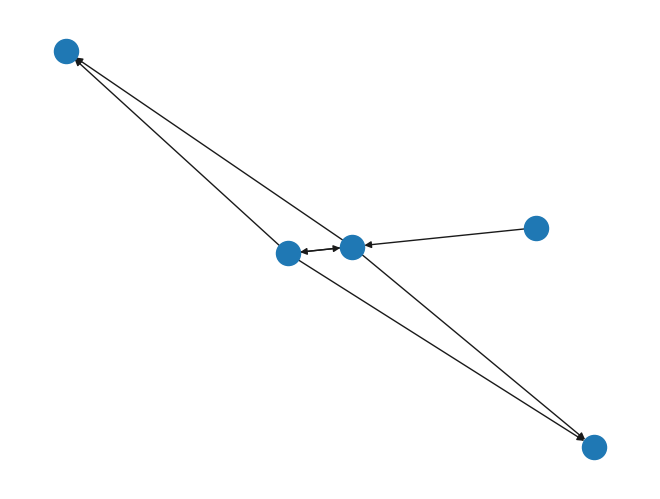

In [42]:
nx.draw(create_graph(nodes, edges))